# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7680\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,5353.01,1.00,-131.89,3168.08,3036.19
OMUSDT,526.32,3535.70,0.66,0.00,3009.38,3009.38
BTCUSDT,601.02,860.08,0.16,3.54,259.06,262.60
SOLUSDT,281.20,345.00,0.06,0.00,63.80,63.80
JASMYUSDT,387.46,286.43,0.05,0.00,-101.03,-101.03
ETHUSDT,250.75,187.63,0.04,0.00,-63.12,-63.12
TRXUSDT,76.87,116.25,0.02,-10.72,39.38,28.66
BBUSDT,60.18,20.79,0.00,-39.73,-39.38,-79.11
BNBUSDT,1.14,1.14,0.00,-10.61,-0.01,-10.62
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

443

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [28]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [29]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [30]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [31]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [32]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [33]:
# pnl_history['Total']

In [34]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [35]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [36]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [37]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [38]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-02-11    2188.155651
2025-02-12    2228.350960
2025-02-13    2214.467462
2025-02-14    2806.571860
2025-02-15    3160.102858
Name: Total, Length: 146, dtype: float64

In [39]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-02-11   -164.205463
2025-02-12     40.195308
2025-02-13    -13.883497
2025-02-14    592.104398
2025-02-15    353.530998
Name: Total, Length: 146, dtype: float64

In [40]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [41]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [42]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [43]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\Admin\AppData\Local\Temp\ipykernel_7680\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [44]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [45]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [46]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

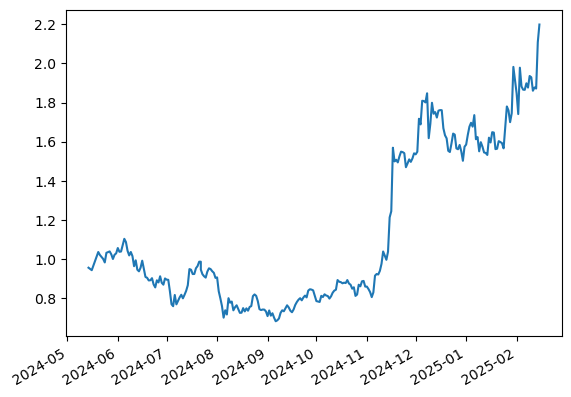

In [47]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

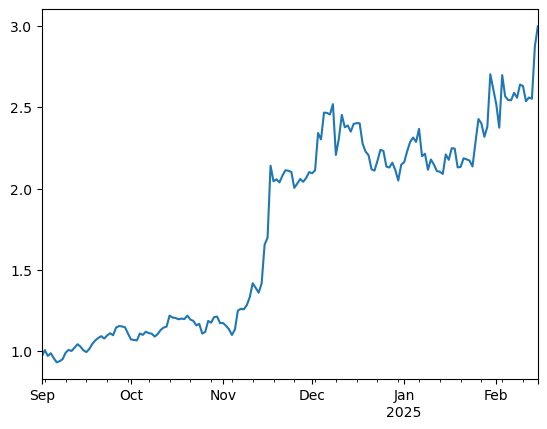

In [48]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [50]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [53]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [54]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [57]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4861
BNBUSDT,0.2642
XRPUSDT,0.1665
SUIUSDT,0.0470
PEPEUSDT,0.0268
AAVEUSDT,0.0090
ADAUSDT,0.0004
RAYUSDT,0.0000
BTCUSDT,0.0000
NEXOUSDT,0.0000


In [58]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

In [59]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

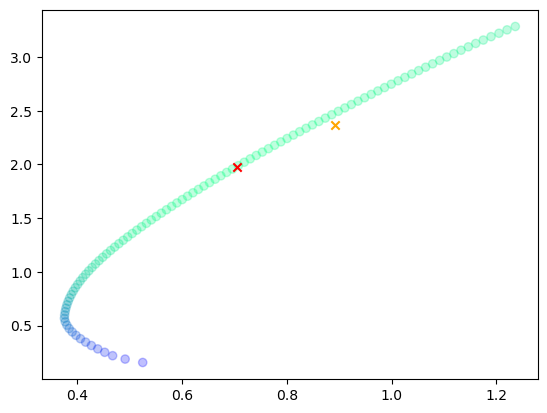

In [60]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [61]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [62]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3535.695225,0.660505,0.2424,0.418105
BTCUSDT,860.080300,0.160672,0.0000,0.160672
SOLUSDT,345.000481,0.064450,0.0000,0.064450
JASMYUSDT,286.433072,0.053509,0.0000,0.053509
ETHUSDT,187.626937,0.035051,0.0000,0.035051
TRXUSDT,116.250510,0.021717,0.0000,0.021717
BBUSDT,20.791218,0.003884,0.0000,0.003884
BNBUSDT,1.136926,0.000212,0.1368,-0.136588
PEPEUSDT,0.000002,0.000000,0.0281,-0.028100
XRPUSDT,0.000000,0.000000,0.1646,-0.164600


### Current results

In [64]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [65]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']

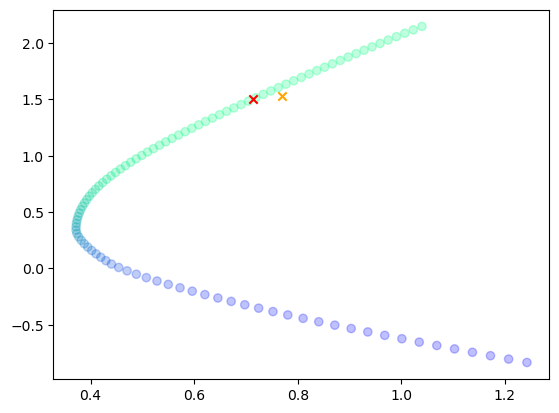

In [66]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [67]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3535.695225,0.660505,0.62070,0.039805
BTCUSDT,860.080300,0.160672,0.26667,-0.105998
SOLUSDT,345.000481,0.064450,0.00000,0.064450
JASMYUSDT,286.433072,0.053509,0.00000,0.053509
ETHUSDT,187.626937,0.035051,0.00000,0.035051
TRXUSDT,116.250510,0.021717,0.11263,-0.090913
BBUSDT,20.791218,0.003884,0.00000,0.003884
BNBUSDT,1.136926,0.000212,0.00000,0.000212
PEPEUSDT,0.000002,0.000000,0.00000,0.000000


# Risk Reward Analysis

In [69]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [70]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

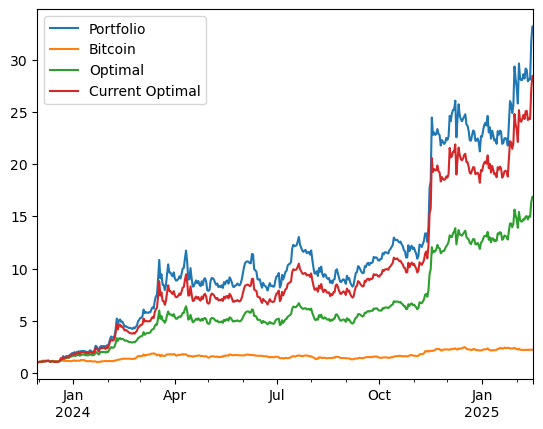

In [71]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [72]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

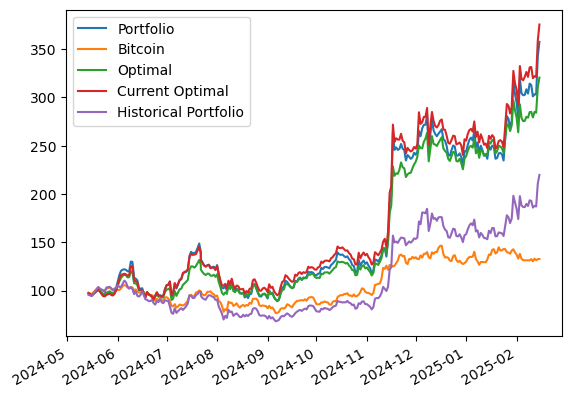

In [73]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [74]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-02-06,302.742204,131.386650,275.754119,321.334821,186.471769
2025-02-07,308.498245,131.321931,280.010354,326.481267,189.817980
2025-02-08,304.039379,131.237455,279.072493,321.351549,187.609350
2025-02-09,314.367232,131.261960,284.879178,331.189192,193.532660
2025-02-10,312.773621,132.572698,285.142440,331.587345,192.899874
2025-02-11,301.152358,130.304712,279.333082,319.975106,186.011212
2025-02-12,303.352817,133.119928,285.146566,322.071905,187.689310
2025-02-13,303.080646,131.392435,284.250754,321.314306,187.139545
2025-02-14,342.568999,132.600497,310.622024,358.777840,210.740797
2025-02-15,357.641636,132.694548,320.604229,375.574647,219.830088


## Volatilities

In [76]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.660114
 dtype: float64,
 0.6608363316346902)

In [77]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.770184
 dtype: float64,
 0.7701836826581205)

In [78]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.891783
Bitcoin            0.422813
Optimal            0.660836
Current Optimal    0.826287
dtype: float64

In [79]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4781283147440141

In [80]:
days=150
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

2.8786535238467823

In [81]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.9835967646417667

## Risk Contribution

In [83]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.173888,0.122922,0.007003,0.037544,0.007735,0.029809
BTCUSDT,0.360477,0.300000,0.015583,0.109271,0.036843,0.072429
OMUSDT,40.596247,0.448421,0.968369,0.794676,0.703276,0.091400
SUIUSDT,0.042675,0.026277,0.001627,0.013389,0.001424,0.011965
XRPUSDT,0.212086,0.102380,0.007419,0.045120,0.010875,0.034245


In [84]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.232868,0.62070,0.877950,0.886774,0.818523,0.068251
BTCUSDT,0.110937,0.26667,0.086029,0.069547,0.022047,0.047500
TRXUSDT,0.045476,0.11263,0.036021,0.043679,0.016438,0.027240


In [85]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.472282,0.666667,0.915183,0.883241,0.810312,0.072929
BTCUSDT,0.067233,0.161616,0.050602,0.040378,0.006949,0.033429
SOLUSDT,0.001834,0.060606,0.013806,0.027277,0.002689,0.024588
JASMYUSDT,-0.018138,0.050505,0.007157,0.031969,0.005202,0.026767
ETHUSDT,-0.008834,0.040404,0.006981,0.011564,0.000807,0.010758
TRXUSDT,0.008157,0.020202,0.006271,0.005570,0.000454,0.005117


# Value At Risk

## Historical

### Optimal Weights

In [89]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04976178833009633, -0.07498200373806481)

### Current Weights

In [91]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05092962944675923, -0.07941717151244412)

In [92]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [93]:
var=historical_var.iloc[row]
var

OMUSDT      -0.042741
BTCUSDT     -0.000419
SOLUSDT     -0.003305
JASMYUSDT   -0.003053
ETHUSDT     -0.001279
TRXUSDT     -0.000090
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050887
Name: 2024-06-17 00:00:00, dtype: float64

In [94]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.063803
BTCUSDT     -0.004013
SOLUSDT     -0.003261
JASMYUSDT   -0.004120
ETHUSDT     -0.001705
TRXUSDT     -0.000614
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.077515
dtype: float64

## Parametric

### Optimal Weights

In [97]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06847324314300036, -0.08776376590610249)

### Current Weights

In [99]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.07980338253644, -0.102285871998444)

## Multivariate

### Optimal Weights

In [102]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06132746517305608, -0.07786559154703634)

### Current Weights

In [104]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07449986418181727, -0.09347092734149778)

In [105]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.062394
BTCUSDT     -0.003829
SOLUSDT     -0.002534
JASMYUSDT   -0.003250
ETHUSDT     -0.001184
TRXUSDT     -0.000355
Portfolio   -0.073547
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [109]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061358137141848644, -0.07948155541198752)

### Current Weights

In [111]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0733600311659054, -0.09242988360868452)

In [112]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.064739
BTCUSDT     -0.003450
SOLUSDT     -0.002083
JASMYUSDT   -0.002246
ETHUSDT     -0.001078
TRXUSDT     -0.000184
Portfolio   -0.073780
dtype: float64

## Student Copula

### Optimal Weights

In [115]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.061545745183040935, -0.07841025861316171)

### Current Weights

In [117]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07833859432372678, -0.0991028444151779)

In [118]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.067594
BTCUSDT     -0.002388
SOLUSDT     -0.001571
JASMYUSDT   -0.002422
ETHUSDT     -0.000876
TRXUSDT     -0.000448
Portfolio   -0.075299
dtype: float64

## Gumbel Copula

### Optimal Weights

In [121]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.12351548344864664, -0.17897723216758094)

### Current Weights

In [123]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1552821086527921, -0.21831062428175585)

In [124]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.154030
BTCUSDT      0.000278
SOLUSDT     -0.000671
JASMYUSDT   -0.000567
ETHUSDT      0.000290
TRXUSDT      0.000138
Portfolio   -0.154563
dtype: float64

## Monte Carlo

### Optimal

In [127]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [128]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06880749540399941, -0.08620889559426541)

### Current Weights

In [130]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08095547736729071, -0.10225012337461638)

In [131]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.072656
BTCUSDT     -0.003125
SOLUSDT     -0.002086
JASMYUSDT   -0.002461
ETHUSDT     -0.000808
TRXUSDT     -0.000300
Portfolio   -0.081437
dtype: float64

## VaR Violation

In [133]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056232,-0.101389,-0.086072,-0.018962
2024-01-15,-0.056232,-0.101368,-0.086176,0.020286
2024-01-16,-0.056232,-0.101490,-0.083347,0.051114
2024-01-17,-0.056232,-0.103813,-0.086170,-0.033322
2024-01-18,-0.056232,-0.105739,-0.088454,-0.029968
...,...,...,...,...
2025-02-12,-0.053052,-0.090579,-0.084742,0.020812
2025-02-13,-0.053052,-0.090556,-0.084425,-0.003142
2025-02-14,-0.053052,-0.095471,-0.090486,0.092775
2025-02-15,-0.053052,-0.095806,-0.088926,0.032136


In [134]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.043687,-0.084227,-0.083464,-0.015236
2024-05-29,-0.043687,-0.082066,-0.081994,-0.007349
2024-05-30,-0.043687,-0.072245,-0.074078,0.026942
2024-05-31,-0.043687,-0.076020,-0.071183,0.048208
2024-06-01,-0.043687,-0.082370,-0.075904,0.065359
...,...,...,...,...
2025-02-12,-0.054391,-0.144545,-0.136385,0.007307
2025-02-13,-0.054391,-0.144176,-0.136115,-0.000897
2025-02-14,-0.054391,-0.138227,-0.128631,0.130290
2025-02-15,-0.054391,-0.136303,-0.123837,0.043999


<Axes: >

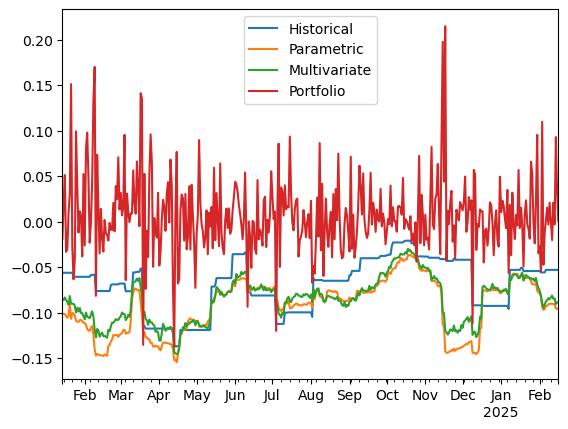

In [135]:
var_data.plot()

<Axes: >

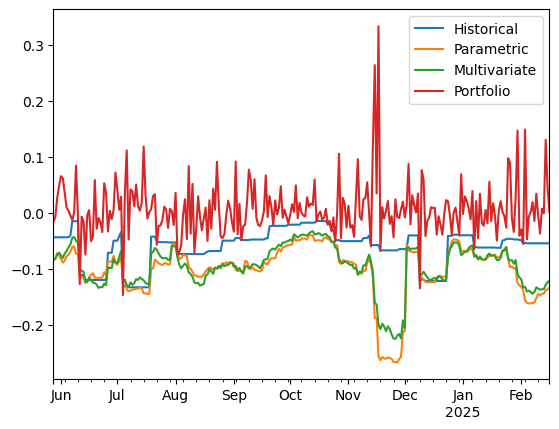

In [136]:
current_var_data.plot()

In [137]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.0225,0.0075,0.01
Kupiec Stat,7.942254,23.366712,19.78892
P-value,0.004829,0.000001,0.000009


In [138]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.056604,0.015094,0.011321
Kupiec Stat,0.233773,9.254158,11.999466
P-value,0.628741,0.00235,0.000532


# Principal Component Analysis

## Historical PCA

In [141]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78682352, 0.06695826, 0.05744842, 0.04946331, 0.03930648])

In [142]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015860
ADAUSDT     0.015765
ALGOUSDT    0.018256
APTUSDT     0.016453
ARBUSDT     0.017647
              ...   
WBTCUSDT    0.008988
WLDUSDT     0.022224
XLMUSDT     0.013169
XRPUSDT     0.011368
XTZUSDT     0.016408
Name: PC1, Length: 62, dtype: float64

<Axes: >

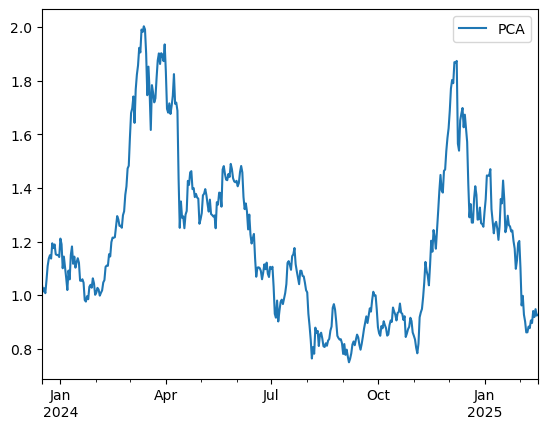

In [143]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

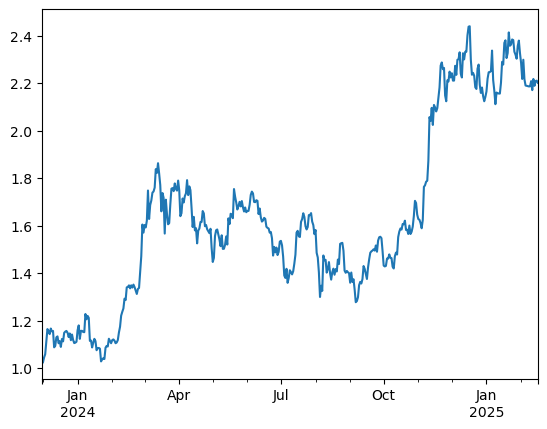

In [144]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [145]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.426961
WBETHUSDT    0.446036
ETHUSDT      0.446296
DOTUSDT      0.468138
ATOMUSDT     0.468842
ETCUSDT      0.471276
NEXOUSDT     0.482363
ADAUSDT      0.521965
EOSUSDT      0.527560
WBTCUSDT     0.529946
BTCUSDT      0.530448
AVAXUSDT     0.531147
IOTAUSDT     0.556369
FILUSDT      0.563900
ARBUSDT      0.573660
GRTUSDT      0.582343
XTZUSDT      0.587160
LINKUSDT     0.599284
SOLUSDT      0.609447
dtype: float64

<Axes: >

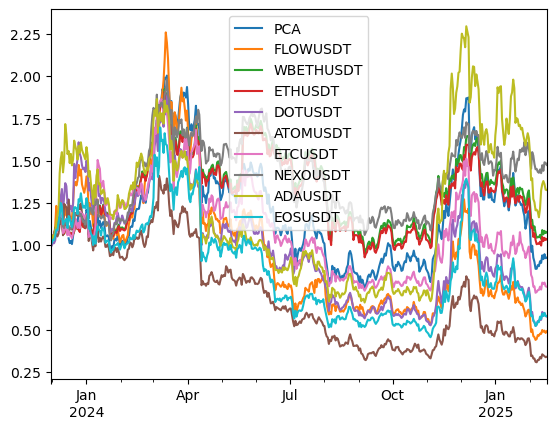

In [146]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

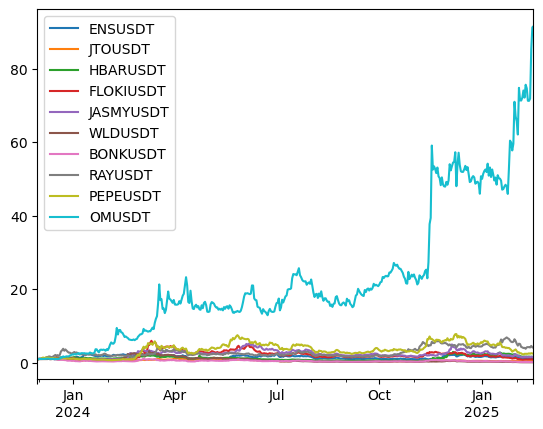

In [147]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [149]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.56779089, 0.14986736, 0.11824335, 0.09377384, 0.07032455])

In [150]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095918
BTCUSDT      0.058933
SOLUSDT      0.097285
JASMYUSDT    0.175847
ETHUSDT      0.084583
TRXUSDT      0.055204
BBUSDT       0.206501
BNBUSDT      0.065816
PEPEUSDT     0.159913
Name: PC1, dtype: float64

<Axes: >

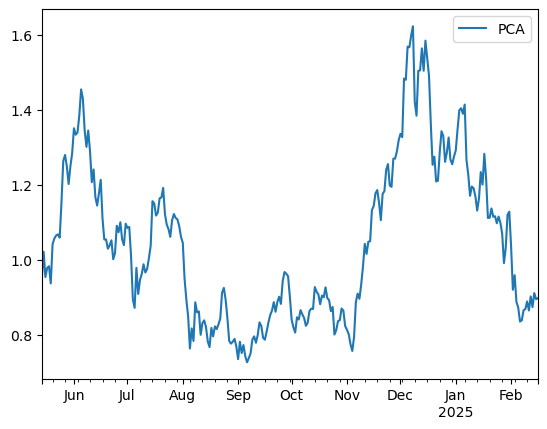

In [151]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

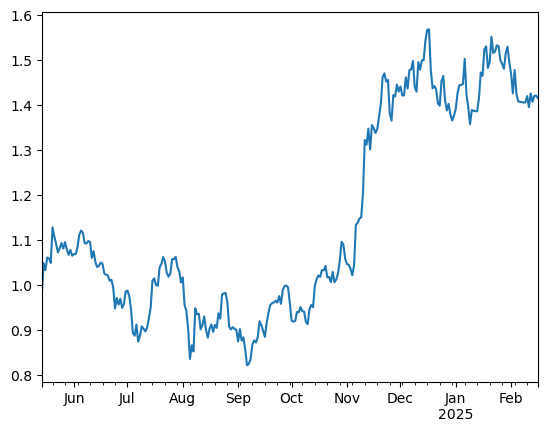

In [152]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.437996
BNBUSDT      0.479495
BTCUSDT      0.495212
SOLUSDT      0.497023
JASMYUSDT    0.694249
PEPEUSDT     0.747392
BBUSDT       0.783093
TRXUSDT      0.910422
OMUSDT       0.994686
dtype: float64

<Axes: >

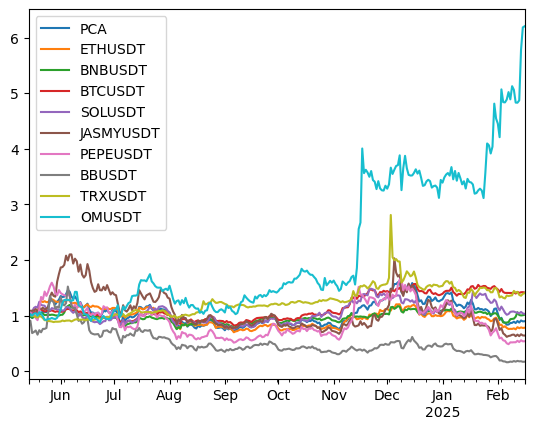

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [156]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.907999
BBUSDT       1.573557
JASMYUSDT    1.348425
SOLUSDT      1.163863
BTCUSDT      1.000000
ETHUSDT      0.974831
OMUSDT       0.897489
BNBUSDT      0.669423
TRXUSDT      0.331431
Name: BTCUSDT, dtype: float64

In [157]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.495113
BBUSDT       2.218051
PEPEUSDT     1.948445
OMUSDT       1.789171
SOLUSDT      1.295533
ETHUSDT      1.021567
BTCUSDT      1.000000
TRXUSDT      0.948028
BNBUSDT      0.920928
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [159]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [160]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.329232
BBUSDT,0.256166
PEPEUSDT,0.152621
ETHUSDT,0.099403
TRXUSDT,0.099357
JASMYUSDT,0.095569
SOLUSDT,0.083179
BNBUSDT,0.046248
OMUSDT,0.023149


### Regression to PCA

In [162]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.5623929849064442

In [163]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.310706
BNBUSDT      1.139371
ETHUSDT      1.027241
PCA          1.000000
SOLUSDT      0.758868
JASMYUSDT    0.442211
PEPEUSDT     0.421430
BBUSDT       0.387933
TRXUSDT      0.263254
OMUSDT       0.239056
dtype: float64

In [164]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.817730
ETHUSDT      1.261851
BNBUSDT      1.007878
TRXUSDT      1.005500
PCA          1.000000
BBUSDT       0.630155
PEPEUSDT     0.622898
JASMYUSDT    0.503083
SOLUSDT      0.357376
OMUSDT       0.279663
dtype: float64

### Correlation Matrix

<Axes: >

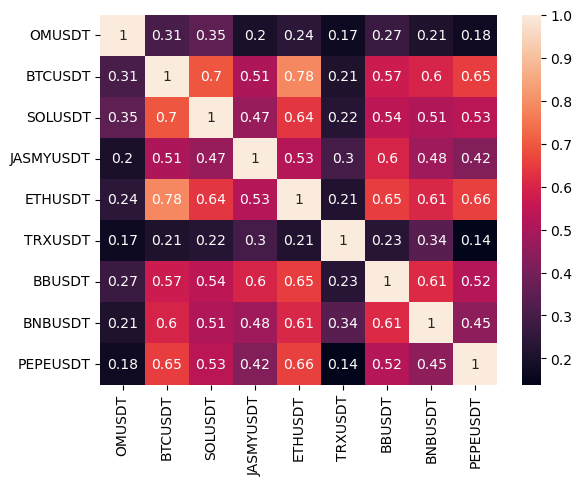

In [166]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

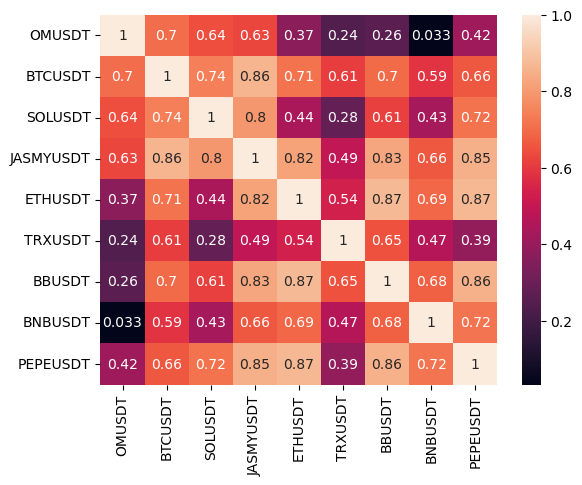

In [167]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [169]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.000000,0.150852,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.112009,0.000000,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [170]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-07-11,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.969643,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-08-10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.667971,0.0
2024-09-09,0.258995,0.026342,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.592994,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-09,0.000000,0.000000,0.0,0.014435,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.477853,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-08,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-08,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.01125,0.0,0.0,0.0,0.0,0.0,0.0,0.045172,0.0
2025-01-07,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-06,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-16,0.000000,0.203465,0.0,0.000000,0.0,0.0,0.0,0.0,0.202885,0.0,...,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.176207,0.0


In [171]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

LTCUSDT    0.230133
ADAUSDT    0.203465
BNBUSDT    0.202885
XRPUSDT    0.176207
OMUSDT     0.142030
IMXUSDT    0.045280
Name: 2025-02-16 00:00:00, dtype: float64